In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import glob
from IPython.display import display

In [6]:
benchmark_results = []
for path in glob.glob('../../benchmarks/2020-12-15-independent-small-regen-1/*.csv'):
    benchmark_results.append(pd.read_csv(path))
benchmark_results = pd.concat(benchmark_results)

benchmark_results.sample(5)

,generation_config_i,input_strategy,input_length_1,input_change_strength,input_chunkiness,input_distribution,regen_i,repetition_i,diff_program,mpi_procs,timeout_seconds,mpi_comm_world,micros_input,micros_precompute,micros_until_len,micros_edit_script,min_edit_length
138,4,independent,76666,1,0,zipf,0,38,sequential_frontier_simd,NaN,NaN,1,11626,0,22367787,0,130722
6,2,independent,53333,1,0,zipf,0,0,mpi_no_master_frontier_simd,2.0,60.0,2,10189,0,6279691,0,90320
157,6,independent,100000,1,0,zipf,0,40,sequential_frontier,NaN,NaN,1,19397,0,59634028,0,171020
37,2,independent,53333,1,0,zipf,0,17,mpi_priority_frontier_simd,64.0,60.0,64,13521,0,811736,0,90320
22,6,independent,100000,1,0,zipf,0,4,mpi_no_master_frontier,4.0,60.0,4,20497,0,15414237,0,171020


0.23894491854150504


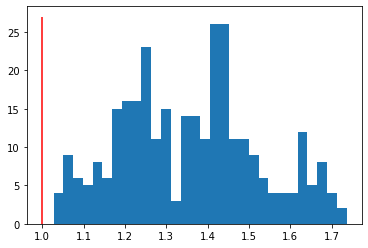

In [14]:
indexed_benchmark_results = benchmark_results.set_index(['generation_config_i', 'diff_program', 'repetition_i', 'mpi_procs'])


temp = indexed_benchmark_results['micros_until_len'].unstack('diff_program')
print((temp.sequential_frontier_simd < temp.sequential_frontier).mean())

hist_values = temp.sequential_frontier / temp.sequential_frontier_simd
#hist_values = hist_values[(hist_values < 50) & (temp.sequential > 1000)]
plt.vlines(1, 0, 27, colors=['Red'])
plt.hist(hist_values, bins=30);

mpi_priority_frontier independent:
0.6585365853658537
mpi_no_master_frontier independent:
1.0
sequential_frontier independent:
1.0


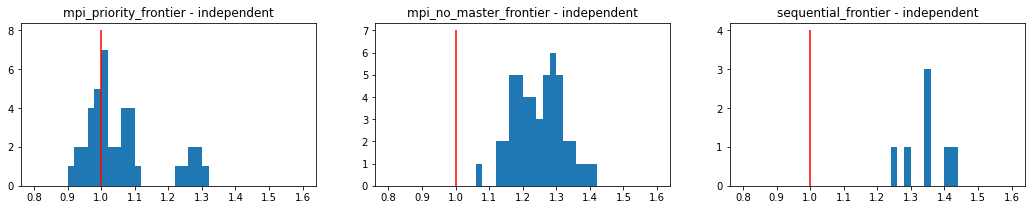

In [13]:
fig, ax = plt.subplots(1, 3, figsize=(18, 3), sharex=False, sharey=False)
input_strategy = 'independent'
for diff_program_i, diff_program in enumerate(['mpi_priority_frontier', 'mpi_no_master_frontier', 'sequential_frontier']):

        if diff_program == 'mpi_priority_frontier':
            rep_max = 19
        else:
            rep_max = 49

        no_simd = benchmark_results[(benchmark_results['diff_program'] == diff_program)].copy()
        no_simd['mpi_procs'] = no_simd['mpi_procs'].fillna('sequential')
        no_simd = no_simd.groupby(['generation_config_i', 'mpi_procs']).agg({
            'repetition_i': 'max',
            'micros_until_len': 'median',
        })

        simd = benchmark_results[(benchmark_results['diff_program'] == diff_program + "_simd")].copy()
        simd['mpi_procs'] = simd['mpi_procs'].fillna('sequential')
        simd = simd.groupby(['generation_config_i', 'mpi_procs']).agg({
            'repetition_i': 'max',
            'micros_until_len': 'median',
        })

        if diff_program != 'sequential_frontier':
            confidence_filter = (no_simd['repetition_i'] != rep_max) & (simd ['repetition_i'] != rep_max)     # exclude values with lower confidence

            no_simd = no_simd[confidence_filter]['micros_until_len']
            simd = simd[confidence_filter]['micros_until_len']
        else:
            no_simd = no_simd['micros_until_len']
            simd = simd['micros_until_len']

        print(diff_program + " " + input_strategy + ":")
        print((simd < no_simd).mean())

        hist_values = no_simd / simd
        #hist_values = hist_values[(hist_values < 50) & (temp.sequential > 1000)]
        ax[diff_program_i].set_title(f'{diff_program} - {input_strategy}')
        if diff_program == 'mpi_priority_frontier':
            hist_max = 8
        else:
            if diff_program == 'mpi_no_master_frontier':
                hist_max = 7
            else:
                hist_max = 4
        ax[diff_program_i].vlines(1, 0, hist_max, colors=['Red'])
        ax[diff_program_i].hist(hist_values, bins=40, range=(0.8, 1.6));